# TEMPLATE for IPTW

created by Kevin Heltemes

requires the dummy dataset "Dataset_for_Programming.xlsx" to be in the same directory

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
#print current working directory. That is, where is this document
os.getcwd()

'/Users/nsheils/Downloads'

In [3]:
#set some pandas options
pd.set_option('display.max_columns', None)

In [4]:
# Descriptions: 
# treat - an indicator variable for participant status.
# MBR_AGE - age in years.
# GENDER = gender indicator
# RISK_TYPE - risk arrangement.
# SEV_LVL_CD - patient acuity.
# PCP_ENC_90D- PCP visit indiator in 90 days after intervention.

In [5]:
#df = pd.read_excel(r'C:\Users\khelteme\Dataset_for_Programming.xlsx',
#                  sheet_name = 'DATA')
file_loc = os.getcwd()+'/Dataset_for_Programming.xlsx'
df = pd.read_excel(file_loc,
                  sheet_name = 'DATA')

In [6]:
df.head()

,COHORT_ID,MBR_AGE,MBR_GDR_CD,GENDER,RISK_TYPE,SEV_LVL_CD,PCP_ENC_90D
0,CTRL,73,F,Female,GLOBAL,1,0
1,Participant,69,F,Female,FFS,1,0
2,Participant,69,F,Female,FFS,1,0
3,Participant,68,F,Female,FFS,1,0
4,CTRL,72,F,Female,GLOBAL,1,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3234 entries, 0 to 3233
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   COHORT_ID    3234 non-null   object
 1   MBR_AGE      3234 non-null   int64 
 2   MBR_GDR_CD   3234 non-null   object
 3   GENDER       3234 non-null   object
 4   RISK_TYPE    3234 non-null   object
 5   SEV_LVL_CD   3234 non-null   int64 
 6   PCP_ENC_90D  3234 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 177.0+ KB


In [8]:
df.describe()

,MBR_AGE,SEV_LVL_CD,PCP_ENC_90D
count,3234.000000,3234.000000,3234.000000
mean,66.713667,1.132344,0.120594
std,16.556970,0.733064,0.325705
min,0.000000,0.000000,0.000000
25%,62.000000,1.000000,0.000000
50%,70.000000,1.000000,0.000000
75%,77.000000,1.000000,0.000000
max,98.000000,4.000000,1.000000


In [9]:
#add a new column to the dataset "treat" which is binary. 1 if patient is a participant, 0 if in control
df.loc[df['COHORT_ID'] == "Participant", 'treat'] = 1
df.loc[df['COHORT_ID'] == "CTRL", 'treat'] = 0

In [10]:
#add a new column "isFemale" which also has binary entries
df.loc[df['GENDER'] == "Female", 'IsFemale'] = 1
df.loc[df['GENDER'] == "Male", 'IsFemale'] = 0

In [11]:
#do the same thing again for new column "IsGlobal"
df.loc[df['RISK_TYPE'] == "GLOBAL", 'IsGlobal'] = 1
df.loc[df['RISK_TYPE'].isin(["FFS", "UNKNOWN", "PROF CAP"]), 'IsGlobal'] = 0

In [12]:
df.describe()

,MBR_AGE,SEV_LVL_CD,PCP_ENC_90D,treat,IsFemale,IsGlobal
count,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000
mean,66.713667,1.132344,0.120594,0.500000,0.623377,0.869821
std,16.556970,0.733064,0.325705,0.500077,0.484614,0.336553
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,62.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,70.000000,1.000000,0.000000,0.500000,1.000000,1.000000
75%,77.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,98.000000,4.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
#df['SEV_LVL_CD'] = pd.to_numeric(df['SEV_LVL_CD'])

In [14]:
df.shape

(3234, 10)

#### estimate propensity scores and calculate weights

In [15]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 

In [16]:
#build a generalized linear model fit to the data
modelresult = smf.glm('treat ~ MBR_AGE + IsFemale + IsGlobal + SEV_LVL_CD', 
                        data=df, 
                        family=sm.families.Binomial()).fit()

modelresult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  treat   No. Observations:                 3234
Model:                            GLM   Df Residuals:                     3229
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2231.3
Date:                Wed, 22 Jun 2022   Deviance:                       4462.6
Time:                        10:01:39   Pearson chi2:                 3.23e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1921      0.162     -1.187      0.235      -0.509       0.125
MBR_AGE       -0.0039      0.002     -1.575      0.115      -0.009       0.001
IsFemale      -0.0235      0.073     -0.321      0.748      -0.167       0.120
IsGlobal       0.5241      0.117      4.495      0.000       0.296       0.753
SEV_LVL_CD     0.0084      0.051      0.165      0.869      -0.091       0.108
==============================================================================
"""

In [17]:
#make predictions using the model on our data
DF_Predictions = pd.DataFrame(modelresult.predict())
DF_Predictions

,0
0,0.508302
1,0.383359
2,0.383359
3,0.384278
4,0.509273
...,...
3229,0.560349
3230,0.533548
3231,0.524795
3232,0.504417


In [18]:
#add these predictions to our dataframe in a column "ps"
df['ps'] = DF_Predictions

In [19]:
df.head()

,COHORT_ID,MBR_AGE,MBR_GDR_CD,GENDER,RISK_TYPE,SEV_LVL_CD,PCP_ENC_90D,treat,IsFemale,IsGlobal,ps
0,CTRL,73,F,Female,GLOBAL,1,0,0.0,1.0,1.0,0.508302
1,Participant,69,F,Female,FFS,1,0,1.0,1.0,0.0,0.383359
2,Participant,69,F,Female,FFS,1,0,1.0,1.0,0.0,0.383359
3,Participant,68,F,Female,FFS,1,0,1.0,1.0,0.0,0.384278
4,CTRL,72,F,Female,GLOBAL,1,0,0.0,1.0,1.0,0.509273


count    3234.000000
mean        0.500000
std         0.039836
min         0.369679
25%         0.502474
50%         0.510395
75%         0.518008
max         0.580340
Name: ps, dtype: float64

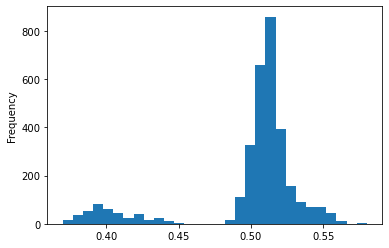

In [20]:
# explore
# plot a histogram of the propensity scores
df.ps.plot(kind='hist', bins=30)
df.ps.describe()

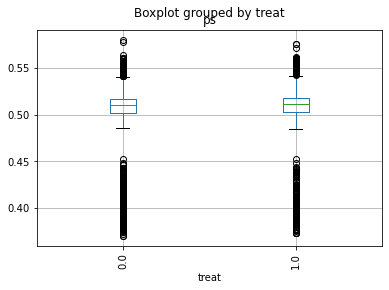

In [21]:
# assess common support
df.boxplot(column='ps', by='treat', rot=90);

In IPTWs, each treated person receives a weight equal to the inverse of the propensity
score

In [22]:
# calculate inverse probability of treatment weights
df.loc[(df['treat'] == 1), 'IPTW'] = (1 / df['ps'])
df.loc[(df['treat'] == 0), 'IPTW'] = (1 / (1 - df['ps']))

In [23]:
df.head()

,COHORT_ID,MBR_AGE,MBR_GDR_CD,GENDER,RISK_TYPE,SEV_LVL_CD,PCP_ENC_90D,treat,IsFemale,IsGlobal,ps,IPTW
0,CTRL,73,F,Female,GLOBAL,1,0,0.0,1.0,1.0,0.508302,2.033768
1,Participant,69,F,Female,FFS,1,0,1.0,1.0,0.0,0.383359,2.608518
2,Participant,69,F,Female,FFS,1,0,1.0,1.0,0.0,0.383359,2.608518
3,Participant,68,F,Female,FFS,1,0,1.0,1.0,0.0,0.384278,2.602280
4,CTRL,72,F,Female,GLOBAL,1,0,0.0,1.0,1.0,0.509273,2.037792


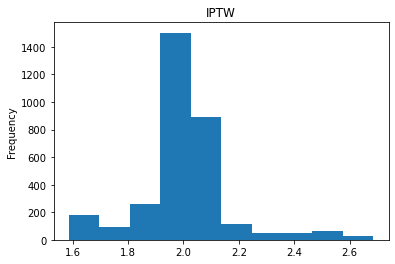

In [24]:
# create a histogram and assess outliers
df['IPTW'].plot(kind='hist', title='IPTW');

In [25]:
df.describe()

,MBR_AGE,SEV_LVL_CD,PCP_ENC_90D,treat,IsFemale,IsGlobal,ps,IPTW
count,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000
mean,66.713667,1.132344,0.120594,0.500000,0.623377,0.869821,0.500000,1.999953
std,16.556970,0.733064,0.325705,0.500077,0.484614,0.336553,0.039836,0.161336
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.369679,1.586493
25%,62.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.502474,1.941229
50%,70.000000,1.000000,0.000000,0.500000,1.000000,1.000000,0.510395,1.994189
75%,77.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.518008,2.054047
max,98.000000,4.000000,1.000000,1.000000,1.000000,1.000000,0.580340,2.685291


In [26]:
# if needed, trim IPTW's
df.groupby(by="treat")['IPTW'].nlargest(5)

treat      
0.0    3186    2.382884
       2806    2.366858
       2813    2.294493
       2924    2.275097
       1616    2.274324
1.0    636     2.685291
       640     2.685291
       641     2.685291
       637     2.678755
       149     2.665760
Name: IPTW, dtype: float64

In [27]:
# Some trimmed threshold value
df = df.loc[df['IPTW'] <= 23]

In [28]:
df.shape

(3234, 12)

In [29]:
# balance diagnostics
# descriptives unmatched or unweighted  data

In [30]:
# split data and use numpy 
trt = df[df['treat'] == 1]  
ctrl = df[df['treat'] == 0] 

In [31]:
trt.columns

Index(['COHORT_ID', 'MBR_AGE', 'MBR_GDR_CD', 'GENDER', 'RISK_TYPE',
       'SEV_LVL_CD', 'PCP_ENC_90D', 'treat', 'IsFemale', 'IsGlobal', 'ps',
       'IPTW'],
      dtype='object')

In [32]:
trt.shape

(1617, 12)

In [33]:
ctrl.shape

(1617, 12)

In [34]:
# descriptives for unmatched or unweighted data
np.average(trt['IsFemale'])

0.6227581941867656

In [35]:
np.average(ctrl['IsFemale'])

0.6239950525664811

In [36]:
# descriptives with weighted data
np.average(trt['MBR_AGE'], weights =  trt['IPTW'])

66.66898883136204

In [37]:
np.average(ctrl['MBR_AGE'], weights = ctrl['IPTW'])

66.67592270703167

In [38]:
cols = ['IsFemale', 'MBR_AGE', 'IsGlobal', 'SEV_LVL_CD']

In [39]:
df_trt = trt[cols]

In [40]:
df_ctrl = ctrl[cols]

In [41]:
from statsmodels.stats.weightstats import DescrStatsW

In [42]:
# Using Dataframe.apply() to apply function add column
def trt_weightedmean(x):
    return DescrStatsW(x, weights=trt['IPTW']).mean
trt_mean = df_trt.apply(trt_weightedmean)

In [43]:
def trt_weightedstddv(x):
    return DescrStatsW(x, weights=trt['IPTW']).std
trt_std = df_trt.apply(trt_weightedstddv)

In [44]:
def ctrl_weightedmean(x):
    return DescrStatsW(x, weights=ctrl['IPTW']).mean
ctrl_mean = df_ctrl.apply(ctrl_weightedmean)

In [45]:
def ctrl_weightedstddv(x):
    return DescrStatsW(x, weights=ctrl['IPTW']).std
ctrl_std = df_ctrl.apply(ctrl_weightedstddv)

In [46]:
trt_mean.head()

IsFemale       0.624178
MBR_AGE       66.668989
IsGlobal       0.870294
SEV_LVL_CD     1.132672
dtype: float64

In [47]:
ctrl_mean.head()

IsFemale       0.623979
MBR_AGE       66.675923
IsGlobal       0.870069
SEV_LVL_CD     1.132361
dtype: float64

In [48]:
Diff_Mean = trt_mean.sub(ctrl_mean)
Diff_Mean

IsFemale      0.000199
MBR_AGE      -0.006934
IsGlobal      0.000225
SEV_LVL_CD    0.000311
dtype: float64

In [49]:
# Pooled standard deviation
Pooled_Std = trt_std.add(ctrl_std) / 2
Pooled_Std

IsFemale       0.484360
MBR_AGE       16.603040
IsGlobal       0.336104
SEV_LVL_CD     0.734704
dtype: float64

In [50]:
SSMD = abs(Diff_Mean / Pooled_Std)
SSMD

IsFemale      0.000411
MBR_AGE       0.000418
IsGlobal      0.000669
SEV_LVL_CD    0.000423
dtype: float64

### estimation of treatment effects

In [51]:
# iptw regression
iptwResults = smf.wls('PCP_ENC_90D ~ treat', data=df, weights = df.IPTW).fit()

In [52]:
iptwResults.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:            PCP_ENC_90D   R-squared:                       0.005
Model:                            WLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     17.37
Date:                Wed, 22 Jun 2022   Prob (F-statistic):           3.16e-05
Time:                        10:01:40   Log-Likelihood:                -961.95
No. Observations:                3234   AIC:                             1928.
Df Residuals:                    3232   BIC:                             1940.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1449      0.008     17.904      0.000       0.129       0.161
treat         -0.0477      0.011     -4.168      0.000      -0.070      -0.025
==============================================================================
Omnibus:                     1393.484   Durbin-Watson:                   0.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4483.767
Skew:                           2.317   Prob(JB):                         0.00
Kurtosis:                       6.435   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
params = iptwResults.params
conf = iptwResults.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']

In [54]:
print(np.exp(conf))

                 5%       95%  Odds Ratio
Intercept  1.137688  1.174363    1.155880
treat      0.932275  0.975062    0.953428
